# Model Evaluation - Logistc Regression and Random Forest Classifier

- Alejandro Hohmann
- Bhanu Muvva
- Chunxia Tong

The purpose of this notebook is to use LogReg and DT. It does not yet use the new features.

# Table of Contents

### - [Staley Logistic Regression - SoCal train](#st16-socal)

### - [Staley Logistic Regression - Random Split](#st16-random)

### - [Random Forest](#RF)

In [1]:
# assign seed now for consistency any time it needs to be used
seed=27

In [1]:
# file structure libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import pickle

# # visualization libraries
from matplotlib import pyplot as plt
#plt.style.use('seaborn-v0_8-pastel')
plt.style.use('seaborn-v0_8-darkgrid')
#plt.style.use('bmh')
#plt.style.use('dark_background')
#plt.style.use('fivethirtyeight')
# Have plots display in notebook
%matplotlib inline
import seaborn as sns

# # ML libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay#, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# bring in full file
# will need for geographic assessment of confusion matrix
file_path = "../../data/data_v08_consolidated.parquet"
df = gpd.read_parquet(file_path)

## Read in Staley Raw Data
    - nulls already excluded

In [3]:
staley_data = pd.read_csv("../../data/ofr20161106-na-omit.csv")
staley_data

,Fire Name,Year,Fire_ID,Fire_SegID,Database,State,UTM_Zone,UTM_X,UTM_Y,Response,...,Peak_I15_mm/h,Peak_I30_mm/h,Peak_I60_mm/h,ContributingArea_km2,PropHM23,dNBR/1000,KF,Acc015_mm,Acc030_mm,Acc060_mm
0,Buckweed,2007,bck,bck_1035,Training,CA,11,368133.5165,3823231.989,0,...,3.2,2.0,2.0,0.378767,0.217933,0.297853,0.250000,0.80,1.0,2.0
1,Buckweed,2007,bck,bck_1090,Training,CA,11,367871.0165,3822984.489,0,...,3.2,2.0,2.0,0.689615,0.061249,0.224896,0.250000,0.80,1.0,2.0
2,Buckweed,2007,bck,bck_1570,Training,CA,11,367503.5165,3821741.989,0,...,3.2,2.0,2.0,2.757312,0.042968,0.065537,0.248541,0.80,1.0,2.0
3,Buckweed,2007,bck,bck_235,Training,CA,11,371108.5165,3824991.989,0,...,1.6,1.2,0.8,0.613415,0.092164,0.141711,0.250000,0.40,0.6,0.8
4,Buckweed,2007,bck,bck_363,Training,CA,11,370763.5165,3824576.989,0,...,1.6,1.2,0.8,0.538875,0.058353,0.210158,0.250000,0.40,0.6,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086,Wallow,2011,wlw,wlw_45357,Test,AZ,12,660343.3581,3727458.835,0,...,63.0,54.0,39.0,1.819213,0.066777,0.373291,0.000000,15.75,27.0,39.0
1087,Wallow,2011,wlw,wlw_45553,Test,AZ,12,660408.3581,3727358.835,0,...,63.0,54.0,39.0,2.325559,0.115890,0.604177,0.000000,15.75,27.0,39.0
1088,Wallow,2011,wlw,wlw_46217,Test,AZ,12,661118.3581,3727658.835,1,...,63.0,54.0,39.0,0.715387,0.112607,0.428204,0.000000,15.75,27.0,39.0
1089,Wallow,2011,wlw,wlw_47409,Test,AZ,12,660698.3581,3725248.835,1,...,63.0,54.0,39.0,1.554356,0.009801,0.187053,0.000000,15.75,27.0,39.0


In [4]:
staley_states =  staley_data['State']

## Staley 16 - SoCal split <a id="st16-socal">

recreate Staley's Logistic Regression and calculate model evaluation metrics

In [5]:
#computing input data just as in Staley'16
staley_data["PropHM23_x_i15"] = staley_data["PropHM23"] * staley_data["Acc015_mm"]
staley_data["dNBR_x_i15"] = staley_data["dNBR/1000"] * staley_data["Acc015_mm"]
staley_data["KF_x_i15"] = staley_data["KF"] * staley_data["Acc015_mm"]

use_cols=["PropHM23_x_i15",
          "dNBR_x_i15", 
          "KF_x_i15",
          "Response",
          "Database",
         ]
staley_data = staley_data[use_cols]
staley_data

,PropHM23_x_i15,dNBR_x_i15,KF_x_i15,Response,Database
0,0.174346,0.238282,0.200000,0,Training
1,0.048999,0.179916,0.200000,0,Training
2,0.034374,0.052430,0.198832,0,Training
3,0.036866,0.056684,0.100000,0,Training
4,0.023341,0.084063,0.100000,0,Training
...,...,...,...,...,...
1086,1.051739,5.879331,0.000000,0,Test
1087,1.825272,9.515783,0.000000,0,Test
1088,1.773559,6.744213,0.000000,1,Test
1089,0.154359,2.946077,0.000000,1,Test


In [6]:
# Split based on Staley criteria (trained on SoCal sites)
X_train = staley_data[staley_data['Database'] == 'Training'].iloc[:,:3]
y_train = staley_data[staley_data['Database'] == 'Training'].iloc[:,3]

X_test = staley_data[staley_data['Database'] == 'Test'].iloc[:,:3]
y_test = staley_data[staley_data['Database'] == 'Test'].iloc[:,3]

Architecture:  LogisticRegression


Training accuracy: 0.8266494178525227
Test accuracy: 0.6257861635220126


Precision (test): 0.35443037974683544


Recall (test): 0.7671232876712328


F1 Score (test): 0.48484848484848486


AUC (test): 0.7177523064020128




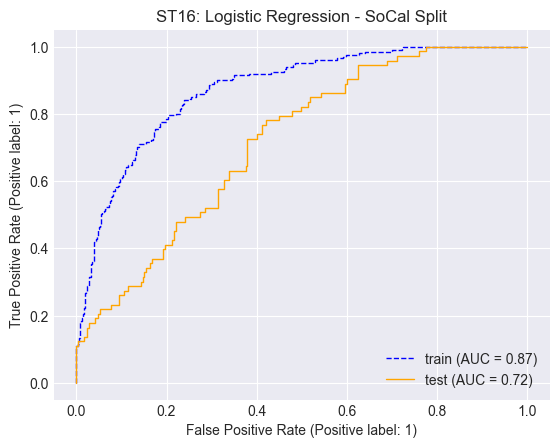

In [7]:
# LogReg SoCal train

# Scale the data
cols = X_train.columns
sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train), columns=cols)
X_test = pd.DataFrame(sc.transform(X_test), columns=cols)

# instantiate and fit model on training data
clf = LogisticRegression(random_state=seed, penalty='l2').fit(X_train, y_train)

# predict training data bool
y_train_pred_proba = clf.predict_proba(X_train)
# it returns the proba complents so get get proba of 1
y_train_pred_proba = pd.DataFrame(y_train_pred_proba)[1]
# predict testing data bool
y_test_pred_proba = clf.predict_proba(X_test)
# it returns the proba complents so get get proba of 1
y_test_pred_proba = pd.DataFrame(y_test_pred_proba)[1]

# predict training data bool
y_train_pred_bool = clf.predict(X_train)
# predict testing data bool
y_test_pred_bool = clf.predict(X_test)

# calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred_bool)
test_accuracy = accuracy_score(y_test, y_test_pred_bool)

# calculate precision
test_precision = precision_score(y_test, y_test_pred_bool, average='binary', zero_division=0)

# calculate recall
test_recall_score = recall_score(y_test, y_test_pred_bool, average='binary', zero_division=0)

# calculate f1
f1_test = f1_score(y_test, y_test_pred_bool)

# extract AUC for printing
auc_test = roc_auc_score(y_test, y_test_pred_proba) 

model_name = clf.__class__.__name__
print(f'Architecture:  {model_name}')
# print(len(params['features']), " features: ")
# print(params['features'])
# print('hyperparameters:')
# param_keys = ['dropout_rate', 'hidden_size', 'lr']
# for key in param_keys:
#     print(key + ":", params[key])
print("\n")

# accuracy
print(f'Training accuracy: {train_accuracy}')
print(f'Test accuracy: {test_accuracy}')
print('\n')

# precision
print(f'Precision (test): {test_precision}')
print('\n')    

# recall
print(f'Recall (test): {test_recall_score}')
print('\n')

# f1
print(f'F1 Score (test): {f1_test}')
print('\n')

# AUC
print(f'AUC (test): {auc_test}')
print('\n')

# plot AUC
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_train, 
                                 y_train_pred_proba,
                                 ax=ax, 
                                 linewidth=1, 
                                 color='blue', 
                                 name='train', 
                                 linestyle="dashed"
                                );

RocCurveDisplay.from_predictions(y_test, 
                                 y_test_pred_proba,
                                 ax=ax, 
                                 linewidth=1, 
                                 color='orange', 
                                 name='test');

plt.title('ST16: Logistic Regression - SoCal Split');

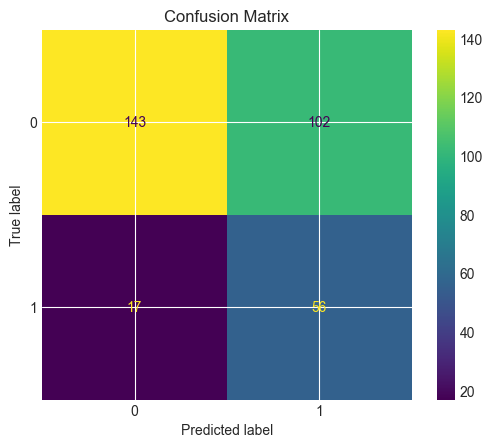

In [8]:
cm = confusion_matrix(y_test, y_test_pred_bool)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();
plt.title('Confusion Matrix');

In [9]:
# create dataframe with test values
test_assess = pd.DataFrame(y_test).astype(int).rename(columns={'Response': 'y_test'})
# predicted values
test_assess['y_test_pred'] = y_test_pred_bool.astype(int)
# whether they are correctly predicted
test_assess['pred_correct'] = test_assess['y_test'] == test_assess['y_test_pred']
# the probability of the prediction
test_assess['y_test_pred_proba'] = y_test_pred_proba.astype(np.float16).values # reduce precision to prevent downstream errors

# create column for confusion matrix
# we'll use this to assess the probabilities
# there's a dataframe for each of these if needed
TP = test_assess[(test_assess['y_test'] == 1) & (test_assess['pred_correct'] == True)]
FP = test_assess[(test_assess['y_test'] == 0) & (test_assess['pred_correct'] == False)]
TN = test_assess[(test_assess['y_test'] == 0) & (test_assess['pred_correct'] == True)]
FN = test_assess[(test_assess['y_test'] == 1) & (test_assess['pred_correct'] == False)]

test_assess.loc[TP.index,'confusion'] = 'TP'
test_assess.loc[FP.index,'confusion'] = 'FP'
test_assess.loc[TN.index,'confusion'] = 'TN'
test_assess.loc[FN.index,'confusion'] = 'FN'

# bring in the state values
test_assess = pd.merge(test_assess, staley_states, how='left', left_index=True, right_index=True)

test_assess

,y_test,y_test_pred,pred_correct,y_test_pred_proba,confusion,State
36,1,1,True,0.957520,TP,NM
37,1,1,True,0.978027,TP,NM
38,1,1,True,0.971680,TP,NM
39,1,1,True,0.943848,TP,NM
40,1,1,True,0.956055,TP,NM
...,...,...,...,...,...,...
1086,0,1,False,0.651855,FP,AZ
1087,0,1,False,0.961914,FP,AZ
1088,1,1,True,0.817383,TP,AZ
1089,1,0,False,0.167480,FN,AZ


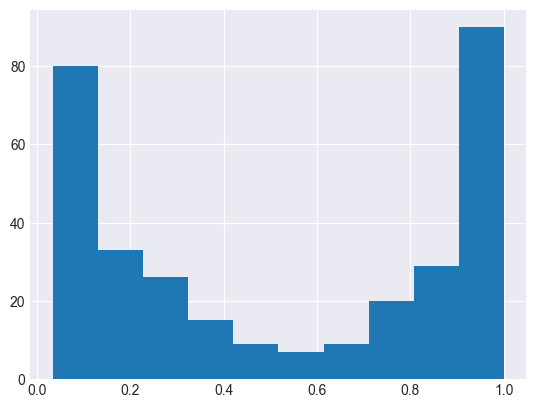

In [10]:
# overall probability distribution
test_assess['y_test_pred_proba'].hist();

In [11]:
# records were there was actually YES debris flow
subset = ['TP', 'FN']
flows = test_assess[test_assess['confusion'].isin(subset)]

# records were there was actually NO debris flow
subset = ['TN', 'FP']
no_flows = test_assess[test_assess['confusion'].isin(subset)]

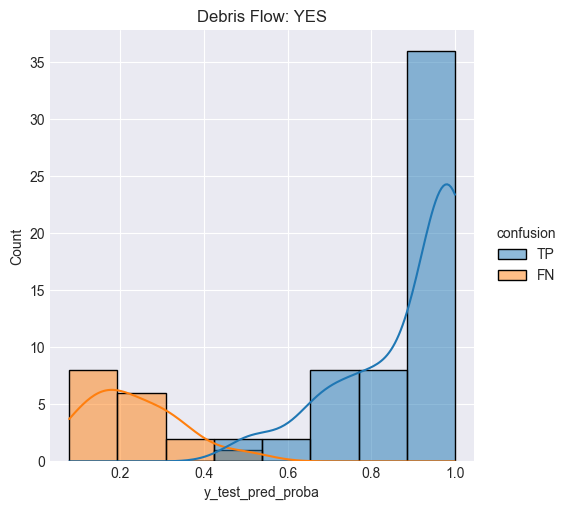

In [12]:
sns.displot(data=flows, x='y_test_pred_proba', hue='confusion', kde=True);
plt.title('Debris Flow: YES');

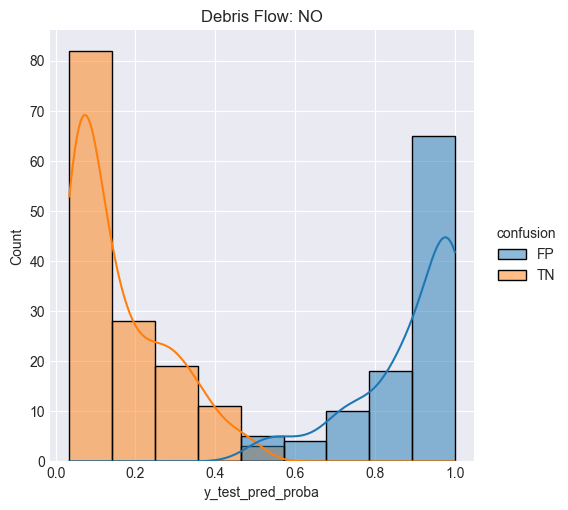

In [13]:
# seaborn has a hard time with the really small probabilities
sns.displot(data=no_flows, x='y_test_pred_proba', hue='confusion', kde=True);
plt.title('Debris Flow: NO');

In [14]:
# this let's us see where are performance is coming from
# it's the percentage of each metric by state
state_matrix = test_assess.groupby(['confusion'])['State'].value_counts(normalize=True).unstack().fillna(0)#.astype(int)
state_matrix = state_matrix.loc[['TP', 'FN', 'TN', 'FP'],:]
state_matrix

State,AZ,CO,NM
confusion,,,
TP,0.071429,0.321429,0.607143
FN,0.176471,0.764706,0.058824
TN,0.251748,0.713287,0.034965
FP,0.401961,0.480392,0.117647


In [15]:
# we can use this to determine
# is our confusion matrix is overindexing on certain state(s)
state_counts = test_assess['State'].value_counts(normalize=True).sort_index()
state_counts

AZ    0.264151
CO    0.572327
NM    0.163522
Name: State, dtype: float64

In [16]:
confusion_index = state_matrix.div(state_counts) - 1
confusion_index

State,AZ,CO,NM
confusion,,,
TP,-0.729592,-0.438383,2.712912
FN,-0.331933,0.336134,-0.640271
TN,-0.046953,0.246292,-0.786175
FP,0.521709,-0.160633,-0.280543


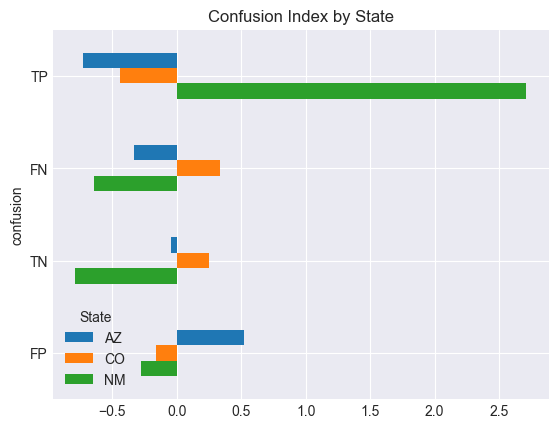

In [17]:
confusion_index.plot(kind='barh').invert_yaxis();
plt.title('Confusion Index by State');

## Staley 16 - random split <a id="st16-random">

recreate Staley's Logistic Regression and calculate model evaluation metrics

In [18]:
# LOAD IN DATA
X_train_df, X_test_df, y_train_df, y_test_df = pickle.load(open("../../data/train_test_data.pkl", "rb"))

print("X_train: ", X_train_df.shape)
print("X_test: ", X_test_df.shape)
print("\n")
print("y_train: ", y_train_df.shape)
print("y_test: ", y_test_df.shape)

X_train:  (1192, 13)
X_test:  (271, 13)


y_train:  (1192,)
y_test:  (271,)


Architecture:  LogisticRegression


Training accuracy: 0.8062080536912751
Test accuracy: 0.8007380073800738


Precision (test): 0.52


Recall (test): 0.23636363636363636


F1 Score (test): 0.325


AUC (test): 0.8476430976430976




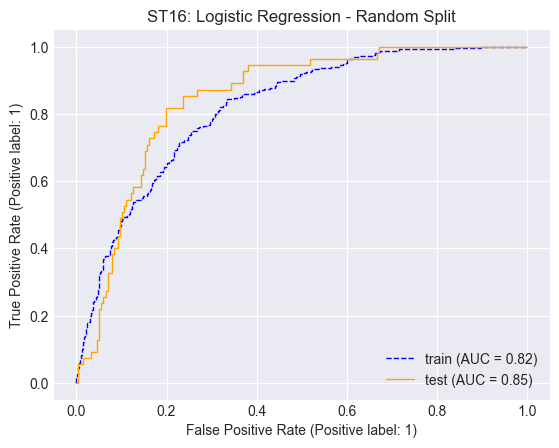

In [19]:
# LogReg SoCal train

#scale the data X_train and X_test
cols = X_train_df.columns
sc = StandardScaler()
X_train_df = pd.DataFrame(sc.fit_transform(X_train_df), columns=cols)
X_test_df = pd.DataFrame(sc.transform(X_test_df), columns=cols)

# instantiate and fit model on training data
clf = LogisticRegression(random_state=seed, penalty='l2').fit(X_train_df, y_train_df)

# predict training data bool
y_train_pred_proba = clf.predict_proba(X_train_df)
# it returns the proba complents so get get proba of 1
y_train_pred_proba = pd.DataFrame(y_train_pred_proba)[1]
# predict testing data bool
y_test_pred_proba = clf.predict_proba(X_test_df)
# it returns the proba complents so get get proba of 1
y_test_pred_proba = pd.DataFrame(y_test_pred_proba)[1]

# predict training data bool
y_train_pred_bool = clf.predict(X_train_df)
# predict testing data bool
y_test_pred_bool = clf.predict(X_test_df)

# calculate accuracy
train_accuracy = accuracy_score(y_train_df, y_train_pred_bool)
test_accuracy = accuracy_score(y_test_df, y_test_pred_bool)

# calculate precision
test_precision = precision_score(y_test_df, y_test_pred_bool, average='binary', zero_division=0)

# calculate recall
test_recall_score = recall_score(y_test_df, y_test_pred_bool, average='binary', zero_division=0)

# calculate f1
f1_test = f1_score(y_test_df, y_test_pred_bool)

# extract AUC for printing
auc_test = roc_auc_score(y_test_df, y_test_pred_proba) 

model_name = clf.__class__.__name__
print(f'Architecture:  {model_name}')
# print(len(params['features']), " features: ")
# print(params['features'])
# print('hyperparameters:')
# param_keys = ['dropout_rate', 'hidden_size', 'lr']
# for key in param_keys:
#     print(key + ":", params[key])
print("\n")

# accuracy
print(f'Training accuracy: {train_accuracy}')
print(f'Test accuracy: {test_accuracy}')
print('\n')

# precision
print(f'Precision (test): {test_precision}')
print('\n')    

# recall
print(f'Recall (test): {test_recall_score}')
print('\n')

# f1
print(f'F1 Score (test): {f1_test}')
print('\n')

# AUC
print(f'AUC (test): {auc_test}')
print('\n')

# plot AUC
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_train_df, 
                                 y_train_pred_proba,
                                 ax=ax, 
                                 linewidth=1, 
                                 color='blue', 
                                 name='train', 
                                 linestyle="dashed"
                                );

RocCurveDisplay.from_predictions(y_test_df, 
                                 y_test_pred_proba,
                                 ax=ax, 
                                 linewidth=1, 
                                 color='orange', 
                                 name='test');

plt.title('ST16: Logistic Regression - Random Split');

## Random Forest Classifier <a id="RF">
- with hyperparameter tuning

In [27]:
# LOAD IN DATA
X_train_df, X_test_df, y_train_df, y_test_df = pickle.load(open("../../data/train_test_data.pkl", "rb"))

print("X_train: ", X_train_df.shape)
print("X_test: ", X_test_df.shape)
print("\n")
print("y_train: ", y_train_df.shape)
print("y_test: ", y_test_df.shape)

X_train:  (1192, 13)
X_test:  (271, 13)


y_train:  (1192,)
y_test:  (271,)


In [28]:
features = X_train_df.columns
features

Index(['peak_i15_mmh', 'contributingarea_km2', 'prophm23', 'dnbr1000', 'kf',
       'Fine fuel load', 'SAV', 'Packing ratio', 'Extinction moisture content',
       'LNDS_RISKS', 'fire_interval', 'SedUn', 'SuscFrac'],
      dtype='object')

In [29]:
# Random Forest
# GRID SEARCH

#scale the data X_train and X_test
cols = X_train_df.columns
sc = StandardScaler()
X_train_df = pd.DataFrame(sc.fit_transform(X_train_df), columns=cols)
X_test_df = pd.DataFrame(sc.transform(X_test_df), columns=cols)


# GRID SEARCH
# instantiate at zer0 before the loop
best_score = 0.0 #

# these are the hyperparameters to search through
param_grid = {
    'max_depth': list(np.arange(20, 120, step=20)) + [None], # none for uncapped
    'n_estimators': np.arange(10, 500, step=50),
    'max_features': [i+1 for i in range(len(features))],
    'min_samples_leaf': [i+1 for i in range(4)],
    'min_samples_split': np.arange(2, 12, step=2)
} 

for params in ParameterGrid(param_grid):
    max_depth = params['max_depth']
    n_estimators = params['n_estimators']
    max_features = params['max_features']
    min_samples_leaf = params['min_samples_leaf']
    min_samples_split = params['min_samples_split']


    # instantiate and fit model on training data
    clf = RandomForestClassifier(
        criterion = 'gini',
        max_depth = max_depth,
        n_estimators = n_estimators,
        max_features = max_features,
        min_samples_leaf = min_samples_leaf,
        min_samples_split = min_samples_split,
        random_state=seed,
        n_jobs=-4
    )

    clf.fit(X_train_df, y_train_df)

    # predict training data bool
    y_train_pred_proba = clf.predict_proba(X_train_df)
    # it returns the proba complents so get get proba of 1
    y_train_pred_proba = pd.DataFrame(y_train_pred_proba)[1]
    # predict testing data bool
    y_test_pred_proba = clf.predict_proba(X_test_df)
    # it returns the proba complents so get get proba of 1
    y_test_pred_proba = pd.DataFrame(y_test_pred_proba)[1]

    # predict training data bool
    y_train_pred_bool = clf.predict(X_train_df)
    # predict testing data bool
    y_test_pred_bool = clf.predict(X_test_df)


    # calculate accuracy
    train_accuracy = accuracy_score(y_train_df, y_train_pred_bool)
    test_accuracy = accuracy_score(y_test_df, y_test_pred_bool)

    # calculate precision
    test_precision = precision_score(y_test_df, y_test_pred_bool, average='binary', zero_division=0)

    # calculate recall
    test_recall_score = recall_score(y_test_df, y_test_pred_bool, average='binary', zero_division=0)

    # calculate f1
    f1_test = f1_score(y_test_df, y_test_pred_bool)

    # extract AUC for printing
    auc_test = roc_auc_score(y_test_df, y_test_pred_proba) 


    # evaluate parameters on given metric and log parameters
    score = auc_test # AUC optimized
    
    if score > best_score:
        best_score = score
        best_params = params

        # and if this is the best, update the dateframe with the given metrics
        best_train_accuracy = train_accuracy
        best_test_accuracy = test_accuracy
        best_precision = test_precision
        best_recall = test_recall_score
        best_f1 = f1_test
        best_auc = auc_test
        
model_name = clf.__class__.__name__
print(f'Architecture:  {model_name}')
print('hyperparameters:')
for key in best_params.keys():
    print(key + ":", best_params[key])
print("\n")

# accuracy
print(f'Training accuracy: {best_train_accuracy}')
print(f'Test accuracy: {best_test_accuracy}')
print('\n')

# precision
print(f'Precision (test): {best_precision}')
print('\n')    

# recall
print(f'Recall (test): {best_recall}')
print('\n')

# f1
print(f'F1 Score (test): {best_f1}')
print('\n')

# AUC
print(f'AUC (test): {best_auc}')
print('\n')

# plot AUC
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_train_df, 
                                 y_train_pred_proba,
                                 ax=ax, 
                                 linewidth=1, 
                                 color='blue', 
                                 name='train', 
                                 linestyle="dashed"
                                );

RocCurveDisplay.from_predictions(y_test_df, 
                                 y_test_pred_proba,
                                 ax=ax, 
                                 linewidth=1, 
                                 color='orange', 
                                 name='test');

plt.title('Random Forest (Random Split)');


KeyboardInterrupt



In [ ]:
# model with the tuned features

# hyperparameters selected from above
max_depth = best_params['max_depth']
n_estimators = best_params['n_estimators']
max_features = best_params['max_features']
min_samples_leaf = best_params['min_samples_leaf']
min_samples_split = best_params['min_samples_split']

# instantiate and fit model on training data
clf = RandomForestClassifier(
    criterion = 'gini',
    max_depth = max_depth,
    n_estimators = n_estimators,
    max_features = max_features,
    min_samples_leaf = min_samples_leaf,
    min_samples_split = min_samples_split,
    random_state=seed,
)

clf.fit(X_train_df, y_train_df)

# predict training data bool
y_train_pred_proba = clf.predict_proba(X_train_df)
# it returns the proba complents so get get proba of 1
y_train_pred_proba = pd.DataFrame(y_train_pred_proba)[1]
# predict testing data bool
y_test_pred_proba = clf.predict_proba(X_test_df)
# it returns the proba complents so get get proba of 1
y_test_pred_proba = pd.DataFrame(y_test_pred_proba)[1]

# predict training data bool
y_train_pred_bool = clf.predict(X_train_df)
# predict testing data bool
y_test_pred_bool = clf.predict(X_test_df)


# calculate accuracy
train_accuracy = accuracy_score(y_train_df, y_train_pred_bool)
test_accuracy = accuracy_score(y_test_df, y_test_pred_bool)

# calculate precision
test_precision = precision_score(y_test_df, y_test_pred_bool, average='binary', zero_division=0)

# calculate recall
test_recall_score = recall_score(y_test_df, y_test_pred_bool, average='binary', zero_division=0)

# calculate f1
f1_test = f1_score(y_test_df, y_test_pred_bool)

# extract AUC for printing
auc_test = roc_auc_score(y_test_df, y_test_pred_proba) 


model_name = clf.__class__.__name__
print(f'Architecture:  {model_name}')
print('hyperparameters:')
for key in best_params.keys():
    print(key + ":", best_params[key])
print("\n")

# accuracy
print(f'Training accuracy: {train_accuracy}')
print(f'Test accuracy: {test_accuracy}')
print('\n')

# precision
print(f'Precision (test): {test_precision}')
print('\n')    

# recall
print(f'Recall (test): {test_recall_score}')
print('\n')

# f1
print(f'F1 Score (test): {f1_test}')
print('\n')

# AUC
print(f'AUC (test): {auc_test}')
print('\n')

# plot AUC
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_train_df, 
                                 y_train_pred_proba,
                                 ax=ax, 
                                 linewidth=1, 
                                 color='blue', 
                                 name='train', 
                                 linestyle="dashed"
                                );

RocCurveDisplay.from_predictions(y_test_df, 
                                 y_test_pred_proba,
                                 ax=ax, 
                                 linewidth=1, 
                                 color='orange', 
                                 name='test');

plt.title('Random Forest (Random Split)');

# Confusion Matrix

In [ ]:
cm = confusion_matrix(y_test_df, y_test_pred_bool)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();
plt.title('Confusion Matrix');

In [150]:
# create dataframe with test values
test_assess = pd.DataFrame(y_test_df).astype(int).rename(columns={'response': 'y_test'})
# predicted values
test_assess['y_test_pred'] = y_test_pred_bool.flatten().astype(int)
# whether they are correctly predicted
test_assess['pred_correct'] = test_assess['y_test'] == test_assess['y_test_pred']
# the probability of the prediction
test_assess['y_test_pred_proba'] = y_test_pred_proba.flatten().astype(np.float16) # reduce precision to prevent downstream errors

# create column for confusion matrix
# we'll use this to assess the probabilities
# there's a dataframe for each of these if needed
TP = test_assess[(test_assess['y_test'] == 1) & (test_assess['pred_correct'] == True)]
FP = test_assess[(test_assess['y_test'] == 0) & (test_assess['pred_correct'] == False)]
TN = test_assess[(test_assess['y_test'] == 0) & (test_assess['pred_correct'] == True)]
FN = test_assess[(test_assess['y_test'] == 1) & (test_assess['pred_correct'] == False)]

test_assess.loc[TP.index,'confusion'] = 'TP'
test_assess.loc[FP.index,'confusion'] = 'FP'
test_assess.loc[TN.index,'confusion'] = 'TN'
test_assess.loc[FN.index,'confusion'] = 'FN'

# bring in the state values
test_assess = pd.merge(test_assess, df['state'], how='left', left_index=True, right_index=True)

test_assess

pred_correct,False,True,total
y_test,,,
0,6,157,163
1,23,30,53


In [ ]:
# overall probability distribution
test_assess['y_test_pred_proba'].hist();

In [ ]:
# records were there was actually YES debris flow
subset = ['TP', 'FN']
flows = test_assess[test_assess['confusion'].isin(subset)]

# records were there was actually NO debris flow
subset = ['TN', 'FP']
no_flows = test_assess[test_assess['confusion'].isin(subset)]

In [ ]:
sns.displot(data=flows, x='y_test_pred_proba', hue='confusion', kde=True);
plt.title('Debris Flow: YES');

In [ ]:
# seaborn has a hard time with the really small probabilities
sns.displot(data=no_flows, x='y_test_pred_proba', hue='confusion', kde=True);
plt.title('Debris Flow: NO');

In [ ]:
# this let's us see where are performance is coming from
# it's the percentage of each metric by state
state_matrix = test_assess.groupby(['confusion'])['state'].value_counts(normalize=True).unstack().fillna(0)#.astype(int)
state_matrix = state_matrix.loc[['TP', 'FN', 'TN', 'FP'],:]
state_matrix

In [ ]:
# we can use this to determine
# is our confusion matrix is overindexing on certain state(s)
state_counts = test_assess['state'].value_counts(normalize=True).sort_index()
state_counts

In [ ]:
confusion_index = state_matrix.div(state_counts) - 1
confusion_index

In [ ]:
confusion_index.plot(kind='barh').invert_yaxis();
plt.title('Confusion Index by State');